In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [2]:
import sys
sys.path.append("..")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from common.utility import to_categorical, torch_device, load_processed_data
from notebook_utils.generate_gaussian import generate_gaussian
from notebook_utils.eigan import Encoder, Discriminator
from notebook_utils.federated import federated
from notebook_utils.eigan_training import distributed_3, centralized_3
from notebook_utils.utility import class_plot, to_numpy
import notebook_utils.metrics as metrics

In [5]:
device='gpu'
device = torch_device(device=device)
device

device(type='cuda')

# Training

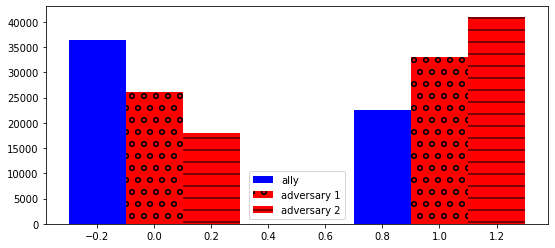

((58976, 168), (58976, 1), (58976, 1), (58976, 1))

In [6]:
X, y_ally, y_advr_1, y_advr_2 = pkl.load(
    open('../checkpoints/mimic/processed_data_X_y_ally_y_advr_y_advr_2.pkl', 'rb'))

y_ally = y_ally.reshape(-1, 1)
y_advr_1 = y_advr_1.reshape(-1, 1)
y_advr_2 = y_advr_2.reshape(-1, 1)


width=0.2
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 4))
ax1.bar(np.unique(y_ally.flatten())-width, np.bincount(y_ally.flatten()), width, color='b')
ax1.bar(np.unique(y_advr_1.flatten()), np.bincount(y_advr_1.flatten()), width, color='r', hatch='o')
ax1.bar(np.unique(y_advr_2.flatten())+width, np.bincount(y_advr_2.flatten()), width, color='r', hatch='-')
ax1.legend(['ally', 'adversary 1', 'adversary 2'])

plt.show()

X.shape, y_ally.shape, y_advr_1.shape, y_advr_2.shape

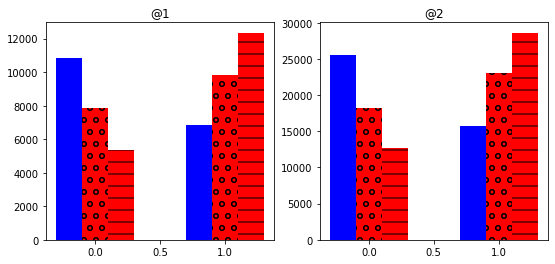

In [7]:
rand_idx = np.random.permutation(X.shape[0])
crossover = int(0.3*X.shape[0])

X1, X2 = X[rand_idx[:crossover]], X[rand_idx[crossover:]] 
y_ally_1, y_ally_2 = y_ally[rand_idx[:crossover]], y_ally[rand_idx[crossover:]]
y_advr_11, y_advr_12 = y_advr_1[rand_idx[:crossover]], y_advr_1[rand_idx[crossover:]]
y_advr_21, y_advr_22 = y_advr_2[rand_idx[:crossover]], y_advr_2[rand_idx[crossover:]]

width=0.2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.bar(np.unique(y_ally_1.flatten())-width, np.bincount(y_ally_1.flatten()), width, color='b')
ax1.bar(np.unique(y_advr_11.flatten()), np.bincount(y_advr_11.flatten()), width, color='r', hatch='o')
ax1.bar(np.unique(y_advr_21.flatten())+width, np.bincount(y_advr_21.flatten()), width, color='r', hatch='-')
ax1.set_title('@1')
ax2.bar(np.unique(y_ally_2.flatten())-width, np.bincount(y_ally_2.flatten()), width, color='b')
ax2.bar(np.unique(y_advr_12.flatten()), np.bincount(y_advr_12.flatten()), width, color='r', hatch='o')
ax2.bar(np.unique(y_advr_22.flatten())+width, np.bincount(y_advr_22.flatten()), width, color='r', hatch='-')
ax2.set_title('@2')
plt.show()

@node 0, X: (17692, 168), y_ally: (17692, 1), y_advr_1: (17692, 1), y_advr_2: (17692, 1)
@node 1, X: (41284, 168), y_ally: (41284, 1), y_advr_1: (41284, 1), y_advr_2: (41284, 1)
@node 0: X_train, X_valid, y_ally_train, y_ally_valid,y_advr_1_train, y_advr_1_valid, y_advr_2_train, y_advr_2_valid
(14153, 168) (3539, 168) (14153, 1) (3539, 1) (14153, 1) (3539, 1) (14153, 1) (3539, 1)
@node 0: class weights => w_ally, w_advr_1, w_advr_2 [array([1.62734276, 2.59402493])] [array([2.25617727, 1.79606599])] [array([3.31451991, 1.43205504])]
@node 0: tensor sizes => torch.Size([14153, 168]) (3539, 168) torch.Size([14153, 2]) (3539, 2) torch.Size([14153, 2]) (3539, 2) torch.Size([14153, 2]) (3539, 2)
@node 1: X_train, X_valid, y_ally_train, y_ally_valid,y_advr_1_train, y_advr_1_valid, y_advr_2_train, y_advr_2_valid
(33027, 168) (8257, 168) (33027, 1) (8257, 1) (33027, 1) (8257, 1) (33027, 1) (8257, 1)
@node 1: class weights => w_ally, w_advr_1, w_advr_2 [array([1.62734276, 2.59402493]), array([1.

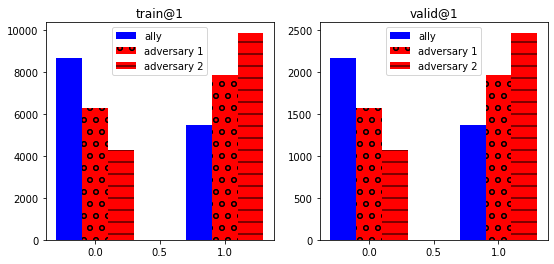

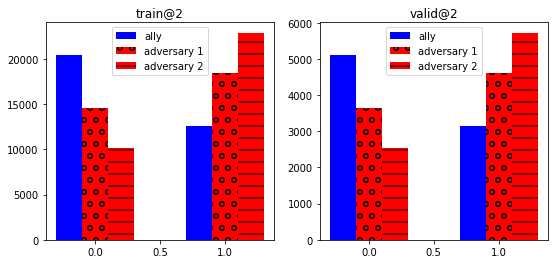

In [8]:
NUM_NODES = 2
BATCHSIZE = 512

X = [X1, X2] 
y_ally = [y_ally_1, y_ally_2]
y_advr_1 = [y_advr_11, y_advr_12]
y_advr_2 = [y_advr_21, y_advr_22]

for _ in range(NUM_NODES):
    print('@node {}, X: {}, y_ally: {}, y_advr_1: {}, y_advr_2: {}'.format(
        _, X[_].shape, y_ally[_].shape, y_advr_1[_].shape, y_advr_2[_].shape))
    
w_ally = []
w_advr_1 = []
w_advr_2 = []
train_loaders = []
X_valids = []
X_trains = []
y_ally_valids = []
y_ally_trains = []
y_advr_1_valids = []
y_advr_1_trains = []
y_advr_2_valids = []
y_advr_2_trains = []
for node_idx in range(NUM_NODES):
    X_local = X[node_idx]
    y_ally_local = y_ally[node_idx]
    y_advr_1_local = y_advr_1[node_idx]
    y_advr_2_local = y_advr_2[node_idx]
    
    X_train, X_valid, y_ally_train, y_ally_valid, \
    y_advr_1_train, y_advr_1_valid, \
    y_advr_2_train, y_advr_2_valid = train_test_split(
        X_local, y_ally_local, y_advr_1_local, y_advr_2_local, test_size=0.2, stratify=pd.DataFrame(
            np.concatenate((y_ally_local, y_advr_1_local, y_advr_2_local), axis=1)
        ))
    print('@node {}: X_train, X_valid, y_ally_train, y_ally_valid,'
          'y_advr_1_train, y_advr_1_valid, y_advr_2_train, y_advr_2_valid'.format(node_idx))
    print(X_train.shape, X_valid.shape, 
          y_ally_train.shape, y_ally_valid.shape,
          y_advr_1_train.shape, y_advr_1_valid.shape, 
          y_advr_2_train.shape, y_advr_2_valid.shape)

    w = np.bincount(y_ally_train.flatten())
    w_ally.append(sum(w)/w)
    w = np.bincount(y_advr_1_train.flatten())
    w_advr_1.append(sum(w)/w)
    w = np.bincount(y_advr_2_train.flatten())
    w_advr_2.append(sum(w)/w)
    print('@node {}: class weights => w_ally, w_advr_1, w_advr_2'.format(node_idx), w_ally, w_advr_1, w_advr_2)

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)
    
    width = 0.2
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    ax1.bar(np.unique(
        y_ally_train.flatten())-width, np.bincount(y_ally_train.flatten()), width, color='b')
    ax1.bar(np.unique(
        y_advr_1_train.flatten()), np.bincount(y_advr_1_train.flatten()), width, color='r', hatch='o')
    ax1.bar(np.unique(
        y_advr_2_train.flatten())+width, np.bincount(y_advr_2_train.flatten()), width, color='r', hatch='-')
    ax1.legend(['ally', 'adversary 1', 'adversary 2'])
    ax1.set_title('train@{}'.format(node_idx+1))
    ax2.bar(np.unique(
        y_ally_valid.flatten())-width, np.bincount(y_ally_valid.flatten()), width, color='b')
    ax2.bar(np.unique(
        y_advr_1_valid.flatten()), np.bincount(y_advr_1_valid.flatten()), width, color='r', hatch='o')
    ax2.bar(np.unique(
        y_advr_2_valid.flatten())+width, np.bincount(y_advr_2_valid.flatten()), width, color='r', hatch='-')
    ax2.legend(['ally', 'adversary 1', 'adversary 2'])
    ax2.set_title('valid@{}'.format(node_idx+1))
    
    y_ally_train = to_categorical(y_ally_train)
    y_ally_valid = to_categorical(y_ally_valid)
    y_advr_1_train = to_categorical(y_advr_1_train)
    y_advr_2_train = to_categorical(y_advr_2_train)
    y_advr_1_valid = to_categorical(y_advr_1_valid)
    y_advr_2_valid = to_categorical(y_advr_2_valid)

    X_train = torch.Tensor(X_train)
    y_ally_train = torch.Tensor(y_ally_train)
    y_advr_1_train = torch.Tensor(y_advr_1_train)
    y_advr_2_train = torch.Tensor(y_advr_2_train)

    X_valids.append(torch.Tensor(X_valid))
    y_ally_valids.append(torch.Tensor(y_ally_valid))
    y_advr_1_valids.append(torch.Tensor(y_advr_1_valid))
    y_advr_2_valids.append(torch.Tensor(y_advr_2_valid))
    
    X_trains.append(X_train)
    y_ally_trains.append(y_ally_train)
    y_advr_1_trains.append(y_advr_1_train)
    y_advr_2_trains.append(y_advr_2_train)

    print('@node {}: tensor sizes =>'.format(node_idx), X_train.shape, X_valid.shape, 
          y_ally_train.shape, y_ally_valid.shape,
          y_advr_1_train.shape, y_advr_1_valid.shape, y_advr_2_train.shape, y_advr_2_valid.shape)

    train_loaders.append(DataLoader(TensorDataset(X_train, y_ally_train, y_advr_1_train, y_advr_2_train), 
                                    batch_size=BATCHSIZE, shuffle=True))
    

In [9]:
alpha = 10
lr_encd = 0.001
lr_ally = 0.001
lr_advr_1 = 0.001
lr_advr_2 = 0.001
n_iter_gan = 501

input_size = X_train.shape[1]
hidden_size = input_size*8
output_size = 2

In [10]:
global_params = {}
encoders = {}

In [11]:
history = {}
history = pkl.load(open('history.pkl', 'rb'))

--------------------------------------------------------------------------------
EIGAN Training w/ phi=1.0 and delta=2
--------------------------------------------------------------------------------
epoch 	 node 	 encoder_train 	 encoder_valid 	 1_train 	 1_valid 	 2_train 	 2_valid 	 3_train 	 3_valid


/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:1334: UserWarning: This overload of add_ is deprecated:
add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
add_(Tensor other, Number alpha)
/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:1550: UserWarning: This overload of addcmul_ is deprecated:
addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcmul_(Tensor tensor1, Tensor tensor2, Number value)
/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:1480: UserWarning: This overload of addcdiv_ is deprecated:
addcdiv_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
addcdiv_(Tensor tensor1, Tensor tensor2, Number value)


0 	 0 	 -4.71876860 	 -4.16684151 	 0.91763133 	 0.96273100 	 0.97180593 	 0.96425802 	 0.99055940 	 0.93499362
0 	 1 	 -3.94748878 	 -4.18469524 	 0.83589292 	 0.80554873 	 0.94586897 	 0.95462787 	 0.91906184 	 0.93069088
Aggregating on epoch: 2...
Aggregating on epoch: 4...
Aggregating on epoch: 6...
Aggregating on epoch: 8...
Aggregating on epoch: 10...
Aggregating on epoch: 12...
Aggregating on epoch: 14...
Aggregating on epoch: 16...
Aggregating on epoch: 18...
Aggregating on epoch: 20...
20 	 0 	 -4.23782730 	 -4.32339287 	 0.64425248 	 0.63178903 	 0.94757408 	 0.95216137 	 0.92704111 	 0.92965120
20 	 1 	 -4.56680298 	 -4.34053707 	 0.65430135 	 0.61371738 	 0.94482410 	 0.95235866 	 0.96358126 	 0.92936116
Aggregating on epoch: 22...
Aggregating on epoch: 24...
Aggregating on epoch: 26...
Aggregating on epoch: 28...
Aggregating on epoch: 30...
Aggregating on epoch: 32...
Aggregating on epoch: 34...
Aggregating on epoch: 36...
Aggregating on epoch: 38...
Aggregating on epoch: 

Aggregating on epoch: 320...
320 	 0 	 -4.43079329 	 -4.33056688 	 0.68298769 	 0.60471386 	 0.94892639 	 0.95237041 	 0.95234025 	 0.92745203
320 	 1 	 -4.15914059 	 -4.27986240 	 0.56564969 	 0.66706026 	 0.95186031 	 0.95226187 	 0.90931302 	 0.92872477
Aggregating on epoch: 322...
Aggregating on epoch: 324...
Aggregating on epoch: 326...
Aggregating on epoch: 328...
Aggregating on epoch: 330...
Aggregating on epoch: 332...
Aggregating on epoch: 334...
Aggregating on epoch: 336...
Aggregating on epoch: 338...
Aggregating on epoch: 340...
340 	 0 	 -4.08226967 	 -4.30896139 	 0.61963934 	 0.60745156 	 0.93515694 	 0.95008278 	 0.92245519 	 0.92785287
340 	 1 	 -4.63787985 	 -4.25693035 	 0.56076652 	 0.68642300 	 0.95910072 	 0.95226187 	 0.95044494 	 0.92836779
Aggregating on epoch: 342...
Aggregating on epoch: 344...
Aggregating on epoch: 346...
Aggregating on epoch: 348...
Aggregating on epoch: 350...
Aggregating on epoch: 352...
Aggregating on epoch: 354...
Aggregating on epoch: 

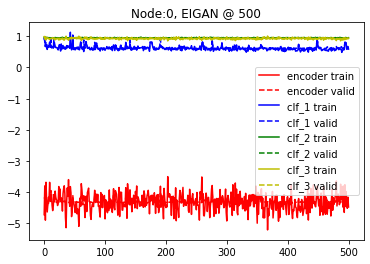

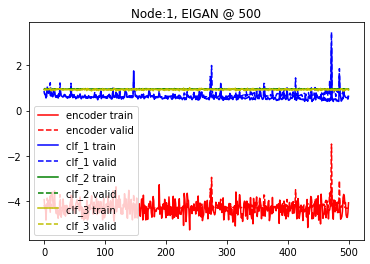

In [12]:
phi = 1.0
delta = 2
print("-"*80)
print('EIGAN Training w/ phi={} and delta={}'.format(phi, delta))
print("-"*80)
encoders['{}_{}'.format(phi, delta)] = distributed_3(NUM_NODES, phi, delta, 
                       X_trains, X_valids, 
                       y_ally_train, y_ally_valids,                            
                       y_advr_1_trains, y_advr_1_valids,
                       y_advr_2_trains, y_advr_2_valids,
                       input_size, hidden_size, [2, 2, 2], 
                       alpha, lr_encd, lr_ally, lr_advr_1, lr_advr_2,w_ally, w_advr_1, w_advr_2,
                       train_loaders, n_iter_gan, device, global_params)

In [ ]:
import pickle as pkl
pkl.dump(encoders, open('encoders_num_nodes_2_phi_delta.pkl', 'wb'))

In [ ]:
import pickle as pkl
encoders = pkl.load(open('encoders_num_nodes_2_phi_delta.pkl', 'rb'))

In [13]:
X_train = torch.cat(X_trains, dim=0).to(device)
X_valid = torch.cat(X_valids, dim=0).to(device)
y_ally_train = torch.cat(y_ally_trains, dim=0).to(device)
y_ally_valid = torch.cat(y_ally_valids, dim=0).to(device)
y_advr_1_train = torch.cat(y_advr_1_trains, dim=0).to(device)
y_advr_1_valid = torch.cat(y_advr_1_valids, dim=0).to(device)
y_advr_2_train = torch.cat(y_advr_2_trains, dim=0).to(device)
y_advr_2_valid = torch.cat(y_advr_2_valids, dim=0).to(device)

  0%|          | 0/501 [00:00<?, ?it/s]

epoch 	 encoder_train 	 encoder_valid 	 1_train 	 1_valid 	 2_train 	 2_valid 	 3_train 	 3_valid


  0%|          | 1/501 [00:02<23:48,  2.86s/it]

0 	 -3.92865992 	 -4.11174965 	 0.58169043 	 0.72476554 	 0.97012955 	 0.95299673 	 0.88923854 	 0.91694915


100%|██████████| 501/501 [24:19<00:00,  2.91s/it]

500 	 -3.56133628 	 39424.46093750 	 0.66450328 	 39429.19531250 	 0.98523593 	 0.95246655 	 0.82362109 	 0.90728259


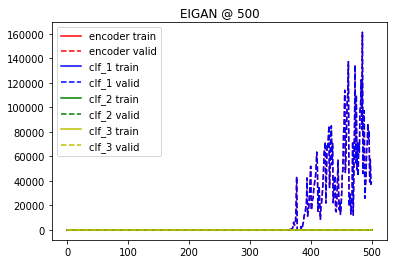

In [14]:
train_loader = DataLoader(TensorDataset(X_train, y_ally_train, y_advr_1_train, y_advr_2_train), batch_size=BATCHSIZE, shuffle=True)

encoder = centralized_3(X_train, X_valid,
                      y_ally_train, y_ally_valid,
                      y_advr_1_train, y_advr_1_valid,
                      y_advr_2_train, y_advr_2_valid,
                      input_size, hidden_size, [2, 2, 2],
                      alpha, lr_encd, lr_ally, lr_advr_1, lr_advr_2, w_ally[0], w_advr_1[0], w_advr_2[0],
                      train_loader, n_iter_gan, device)

In [ ]:
import pickle as pkl
pkl.dump(encoder, open('encoder_num_nodes_2_phi_delta.pkl', 'wb'))

In [ ]:
import pickle as pkl
encoder = pkl.load(open('encoder_num_nodes_2_phi_delta.pkl', 'rb'))

In [ ]:
history.keys()

In [ ]:
print("-"*80)
print('ALLY: BASELINE')
print("-"*80)
history['baseline_ally'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_ally_train, y_ally_valid, 
                                             w_ally[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 1: BASELINE')
print("-"*80)
history['baseline_advr_1'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_advr_1_train, y_advr_1_valid, 
                                             w_advr_1[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 2: BASELINE')
print("-"*80)
history['baseline_advr_2'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_advr_2_train, y_advr_2_valid, 
                                             w_advr_2[0], device, ['mlp', 'logistic'])

In [17]:
NUM_NODES = 2
X_trains = [_.to(device) for _ in X_trains]
X_valids = [_.to(device) for _ in X_valids]
y_ally_trains = [_.to(device) for _ in y_ally_trains]
y_ally_valids = [_.to(device) for _ in y_ally_valids]
y_advr_1_trains = [_.to(device) for _ in y_advr_1_trains]
y_advr_1_valids = [_.to(device) for _ in y_advr_1_valids]
y_advr_2_trains = [_.to(device) for _ in y_advr_2_trains]
y_advr_2_valids = [_.to(device) for _ in y_advr_2_valids]

In [ ]:
print("-"*80)
print('ALLY: CENTRALIZED on 0 local')
print("-"*80)
history['baseline_ally_0'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_trains[0], X_valids[0], y_ally_trains[0], y_ally_valids[0], 
                                             w_ally[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY: CENTRALIZED')
print("-"*80)
history['baseline_advr_1_0'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_trains[0], X_valids[0], y_advr_1_trains[0], y_advr_1_valids[0],
                                             w_advr_1[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY: CENTRALIZED')
print("-"*80)
history['baseline_advr_2_0'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_trains[0], X_valids[0], y_advr_2_trains[0], y_advr_2_valids[0],
                                             w_advr_2[0], device, ['mlp', 'logistic'])

In [ ]:
print("-"*80)
print('ALLY: CENTRALIZED on 1 local')
print("-"*80)
history['baseline_ally_1'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_trains[1], X_valids[1], y_ally_trains[1], y_ally_valids[1], 
                                             w_ally[1], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 1: CENTRALIZED')
print("-"*80)
history['baseline_advr_1_1'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_trains[1], X_valids[1], y_advr_1_trains[1], y_advr_1_valids[1],
                                             w_advr_1[1], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 2: CENTRALIZED')
print("-"*80)
history['baseline_advr_2_1'] = metrics.centralized(None, 
                                             input_size, hidden_size, output_size, 
                                             X_trains[1], X_valids[1], y_advr_2_trains[1], y_advr_2_valids[1],
                                             w_advr_2[1], device, ['mlp', 'logistic'])

In [15]:
print("-"*80)
print('ALLY: CENTRALIZED')
print("-"*80)
history['centralized_ally'] = metrics.centralized(encoder, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_ally_train, y_ally_valid, 
                                             w_ally[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 1: CENTRALIZED')
print("-"*80)
history['centralized_advr_1'] = metrics.centralized(encoder, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_advr_1_train, y_advr_1_valid, 
                                             w_advr_1[0], device, ['mlp', 'logistic'])

print("-"*80)
print('ADVERSARY 2: CENTRALIZED')
print("-"*80)
history['centralized_advr_2'] = metrics.centralized(encoder, 
                                             input_size, hidden_size, output_size, 
                                             X_train, X_valid, y_advr_2_train, y_advr_2_valid, 
                                             w_advr_2[0], device, ['mlp', 'logistic'])

--------------------------------------------------------------------------------
ALLY: CENTRALIZED
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.029824 	 1.030043 	 0.5109
200 	 0.627404 	 0.670414 	 0.7679
400 	 0.627701 	 0.673060 	 0.7210
600 	 0.627239 	 0.677610 	 0.7678
800 	 0.626955 	 0.682616 	 0.7681
1000 	 0.627698 	 0.689897 	 0.7211
Accuracy: 0.7678874194642251
Error Rate: 0.23211258053577483
F1 Score: 0.5985337243401759
Logistic Regression
--------------------------------------------------------------------------------
Accuracy: 0.7207527975584944
Error Rate: 0.2792472024415056
F1 Score: 0.698241113961158
--------------------------------------------------------------------------------
ADVERSARY 1: CENTRALIZED
----------------------

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.49423533401152936
Error Rate: 0.5057646659884707
F1 Score: 0.4389693436148204
--------------------------------------------------------------------------------
ADVERSARY 2: CENTRALIZED
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.020249 	 1.020076 	 0.6951
200 	 0.920099 	 0.926362 	 0.6980
400 	 0.917186 	 0.930395 	 0.6985
600 	 0.916202 	 0.935961 	 0.6979
800 	 0.915961 	 0.938381 	 0.6983
1000 	 0.915317 	 0.941575 	 0.6985
Accuracy: 0.6977789081044422
Error Rate: 0.3022210918955578
F1 Score: 0.8198494112890999
Logistic Regression
--------------------------------------------------------------------------------
Accuracy: 0.6687012546625974
Error Rate: 0.3312987453374025
F1 Score: 0.7888480657013184


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [18]:
for key, encd in encoders.items():
    print("-"*80)
    print('ALLY: {}'.format(key))
    print("-"*80)
    history['decentralize_ally_{}'.format(key)] = metrics.distributed(encd, NUM_NODES,
                                                         input_size, hidden_size, output_size, 
                                                         X_trains, X_valids, y_ally_trains, y_ally_valids, 
                                                         w_ally[0], device, ['mlp', 'logistic'])
    print("-"*80)
    print('ADVERSARY 1: {}'.format(key))
    print("-"*80)
    history['decentralized_advr_1_{}'.format(key)] = metrics.distributed(encd, NUM_NODES,
                                                                     input_size, hidden_size, output_size, 
                                                                     X_trains, X_valids, y_advr_1_trains, y_advr_1_valids, 
                                                                     w_advr_1[0], device, ['mlp', 'logistic'])
    
    print("-"*80)
    print('ADVERSARY: {}'.format(key))
    print("-"*80)
    history['decentralized_advr_2_{}'.format(key)] = metrics.distributed(encd, NUM_NODES,
                                                                     input_size, hidden_size, output_size, 
                                                                     X_trains, X_valids, y_advr_2_trains, y_advr_2_valids, 
                                                                     w_advr_2[0], device, ['mlp', 'logistic'])

--------------------------------------------------------------------------------
ALLY: 1.0_2
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.051140 	 1.051256 	 0.2852
200 	 0.571974 	 0.614571 	 0.7960
400 	 0.570802 	 0.614753 	 0.7964
600 	 0.573942 	 0.618675 	 0.7962
800 	 0.568963 	 0.615449 	 0.7969
1000 	 0.568319 	 0.615532 	 0.7972
Accuracy: 0.7969650729060699
Error Rate: 0.20303492709393015
F1 Score: 0.7127952991965463
Logistic Regression
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.7970498474059003
Error Rate: 0.2029501525940997
F1 Score: 0.7117746207560799
--------------------------------------------------------------------------------
ADVERSARY 1: 1.0_2
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.030157 	 1.030027 	 0.5638
200 	 0.943202 	 0.950234 	 0.5615
400 	 0.940921 	 0.955135 	 0.5582
600 	 0.939710 	 0.963042 	 0.5582
800 	 0.938861 	 0.969992 	 0.5639
1000 	 0.937274 	 0.975208 	 0.5599
Accuracy: 0.5626483553747033
Error Rate: 0.4373516446252967
F1 Score: 0.6787071059351062
Logistic Regression
--------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.5256018989487962
Error Rate: 0.4743981010512038
F1 Score: 0.5325760106916136
--------------------------------------------------------------------------------
ADVERSARY: 1.0_2
--------------------------------------------------------------------------------
MLP
--------------------------------------------------------------------------------
epoch 	 mlp_train 	 mlp_valid 	 v_acc
--------------------------------------------------------------------------------
0 	 1.034391 	 1.034379 	 0.6933
200 	 0.914475 	 0.925914 	 0.7017
400 	 0.908824 	 0.931403 	 0.6891
600 	 0.910875 	 0.937172 	 0.6890
800 	 0.906821 	 0.943738 	 0.6851
1000 	 0.905532 	 0.944653 	 0.6872
Accuracy: 0.688708036622584
Error Rate: 0.31129196337741605
F1 Score: 0.8086503387180823
Logistic Regression
--------------------------------------------------------------------------------
Accuracy: 0.6210579857578841
Error Rate: 0.378942014242116
F1 Score: 0.728729214710523


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
history = pkl.load(open('history_mimic_sample_dist.pkl', 'rb'))

In [ ]:
pkl.dump(history, open('history_mimic_sample_dist.pkl', 'wb'))

In [ ]:
history['decentralized_advr_1.0_7']

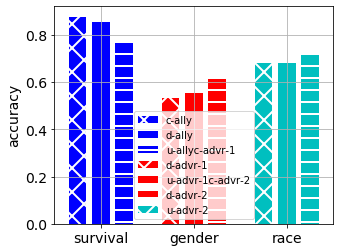

In [58]:
baseline_ally = []
baseline_advr_1 = []
baseline_advr_2 = []
eigan_ally = []
eigan_advr_1 = []
eigan_advr_2 = []
dist_x = []
dist_ally = []
dist_advr_1 = []
dist_advr_2 = []

fig, (ax1) = plt.subplots(1, figsize=(5, 4))

tmp = h['baseline_ally'][2]
baseline_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['baseline_advr_1'][2]
baseline_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = h['baseline_advr_2'][2]
baseline_advr_2.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['centralized_ally'][2]
eigan_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['centralized_advr_1'][2]
eigan_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['centralized_advr_2'][2]
eigan_advr_2.append(max(tmp['logistic'], tmp['mlp']))

phi = 1.0
delta = 2
dist_x.append(phi)
tmp = history['decentralize_{}_{}_{}'.format('ally', phi, delta)][2]
dist_ally.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['decentralized_{}_1_{}_{}'.format('advr', phi, delta)][2]
dist_advr_1.append(max(tmp['logistic'], tmp['mlp']))
tmp = history['decentralized_{}_2_{}_{}'.format('advr', phi, delta)][2]
dist_advr_2.append(max(tmp['logistic'], tmp['mlp']))

ax1.bar(0,eigan_ally[0], color='b', width=0.075, hatch='x')
ax1.bar(0.1, dist_ally, width=0.075, color='b')
ax1.bar(0.2, baseline_ally[0], width=0.075, color='b', hatch='-')


ax1.bar(0.4, eigan_advr_1[0], width=0.075, color='r', hatch = 'x')
ax1.bar(0.5, dist_advr_1, width=0.075, color='r')
ax1.bar(0.6, baseline_advr_1[0], width=0.075, color='r', hatch='-')


ax1.bar(0.8, eigan_advr_2[0], width=0.075, color='c', hatch = 'x')
ax1.bar(0.9, dist_advr_2, width=0.075, color='c')
ax1.bar(1.0, baseline_advr_2[0], width=0.075, color='c', hatch='-')

ax1.set_xticks(dist_x)
ax1.set_xlim(left=-0.1, right=1.1)
ax1.legend(['c-ally', 'd-ally', 'u-ally' 'c-advr-1', 'd-advr-1', 'u-advr-1' 'c-advr-2', 'd-advr-2', 'u-advr-2']
          , prop={'size': 10})
# ax1.set_xlabel('fraction of parameters shared')
ax1.set_ylabel('accuracy')
# ax1.set_title('(a)', y=-0.3)
ax1.grid()
ax1.set_xticks([0.1, 0.5, 0.9])
ax1.set_xticklabels(['survival', 'gender', 'race'])


# plt.rcParams.update({'font.size': 14})
plt.rcParams['hatch.color'] = 'white'
plt.rcParams['hatch.linewidth'] = 2.0
fig.subplots_adjust(wspace=0.3)
plt.savefig('distributed_eigan_mimic_comparison.png', bbox_inches='tight', dpi=300)